#Brain Tumor Segmentation Using Enhanced 3D U-Net Model

##Hani Jandali
##AAI-521 - Computer Vision, Group 14
##December 9th, 2024

#Introduction

The below project is a segmentation and masking og gliomas using using multi-parametric MRI (mpMRI) data. The dataset includes:

1. **MRI Modalities**:
   - Native T1-weighted (T1)
   - Post-contrast T1-weighted (T1Gd)
   - T2-weighted (T2)
   - T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

2. **File Format**:
   - MRI scans are provided as **NIfTI files (.nii.gz)**.

3. **Annotations**:
   - Tumor sub-regions are segmented and labeled as:
     - **GD-enhancing tumor (ET)**: Label 4
     - **Peritumoral edematous/invaded tissue (ED)**: Label 2
     - **Necrotic tumor core (NCR)**: Label 1

4. **Data Preprocessing**:
   - Images are **co-registered** to a common anatomical template.
   - Interpolated to a uniform voxel resolution of **1 mm³**.
   - Skull-stripped.

5. **Clinical Background**:
   - The dataset includes **multi-institutional, routine clinically-acquired mpMRI scans**.
   - All scans are pathologically confirmed and have MGMT promoter methylation status.

This dataset is designed for tumor segmentation, masking, and classification.Ground truth annotations validated by expert neuroradiologists.


 - Our first step is loading in the segmentation models for 3D data to handle our data and utilize pre-built loss functions

In [1]:
!pip install segmentation-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


 - Once loaded, we will require all of the following libraries for annotated reasons

In [2]:
#Libraries and imports
#Nibabel for reading medical imaging files in NIfTI format (.nii or .nii.gz)
import nibabel as nib
#Numerical computations and importantly array manipulation
import numpy as np
import cv2
import imageio
import random
#File path operations
import os
import shutil
#Pattern matching and retrieving file paths
import glob
#Important visualization for preprocessing and results
import matplotlib.pyplot as plt
#DL library
import tensorflow as tf
import zipfile
from IPython.display import Image, display
from tensorflow import keras
#Autodownload files
from google.colab import files
#Mixed precision for faster computation and reduced memory usage
from tensorflow.keras import mixed_precision
#All layers necessary to UNet model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Conv3DTranspose, Cropping3D, ZeroPadding3D
#For Importing model after training
from tensorflow.keras.models import Model, load_model
#Converting segmentation masks into one-hot encoded forms
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import register_keras_serializable
#Standard Classification of loss
from tensorflow.keras.losses import CategoricalCrossentropy
#Important callback fo radjusting learning rate while training and saving checkpoints
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
#Splitting data into training and validation sets
from sklearn.model_selection import train_test_split
#Data augmentation like rotating and filtering
from scipy.ndimage import rotate, gaussian_filter
#Loss function for segmentation
from segmentation_models_3D.losses import DiceLoss
#Metrics to evaluatate segmentation accuracy
from segmentation_models_3D.metrics import IOUScore, FScore

Segmentation Models: using `keras` framework.


#EDA and Preprocessing

 - The first step to understanding our dataset is streaming in the data. Given the size of the data (13.4 GB) it must be stored somewhere relatively accessible. Here we use Google Drive.

In [3]:
#Data stored in google drive, access via below import
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Defined base path to the BraTS dataset (unzipped in .nii.gz format)
base_path = '/content/drive/My Drive/BraTS2021/'

 - Computational complexity and resource management is a central theme to this project. One approach to reduce resource strain is setting a global policy to optimize memory usage

In [5]:
#Mixed precision policy set from beginning to optimize memory usage and improve training times
mixed_precision.set_global_policy('mixed_float16')

 - The below function is our primary method of streaming in data. It initializes empty lists for each modality of the dataset before searching through our nested folders within the Google Drive saved dataset and accumulating each file into it's respective modality.

In [6]:
#Function to load all file paths for each modality (FLAIR, T1, T1CE, T2, and Segmentation)
def load_files(base_path):
    #Initialize empty lists to load all data accordingly
    flair_files = []
    t1_files = []
    t1ce_files = []
    t2_files = []
    seg_files = []

    #For loop to traverse through all folders and subfolders in the base path and find appropriate files
    for root, _, files in os.walk(base_path):
        for file in files:
            #FLAIR Files
            if file.endswith('_flair.nii') or file.endswith('_flair.nii.gz'):
                flair_files.append(os.path.join(root, file))
            #T1 Files
            elif file.endswith('_t1.nii') or file.endswith('_t1.nii.gz'):
                t1_files.append(os.path.join(root, file))
            #T1CE Files
            elif file.endswith('_t1ce.nii') or file.endswith('_t1ce.nii.gz'):
                t1ce_files.append(os.path.join(root, file))
            #T2 Files
            elif file.endswith('_t2.nii') or file.endswith('_t2.nii.gz'):
                t2_files.append(os.path.join(root, file))
            #Segmentation mask files
            elif file.endswith('_seg.nii') or file.endswith('_seg.nii.gz'):
                seg_files.append(os.path.join(root, file))
    return flair_files, t1_files, t1ce_files, t2_files, seg_files

#Load in the file paths for each modality
flair_files, t1_files, t1ce_files, t2_files, seg_files = load_files(base_path)

#Print out the number of files found for each modality to ensure full data loading
print(f"Number of FLAIR files: {len(flair_files)}")
print(f"Number of T1 files: {len(t1_files)}")
print(f"Number of T1CE files: {len(t1ce_files)}")
print(f"Number of T2 files: {len(t2_files)}")
print(f"Number of Segmentation files: {len(seg_files)}")

Number of FLAIR files: 1253
Number of T1 files: 1253
Number of T1CE files: 1253
Number of T2 files: 1253
Number of Segmentation files: 1253


 - As confirmed above, the files are properly streamed in. We have 1,253 instances across all modalities as expected.

In [7]:
#Double check if the number of files is consistent across all modalities and no discrete discrepencies in data
assert len(flair_files) == len(t1_files) == len(t1ce_files) == len(t2_files) == len(seg_files), "Mismatch in the number of files across modalities."
print("All modalities have a consistent number of files.")

All modalities have a consistent number of files.


In [8]:
#Function to load and display the shape of a sample file from each modality
def size_verify(flair_file, t1_file, t1ce_file, t2_file, seg_file):
    try:
        #Load and print FLAIR file
        flair_img = nib.load(flair_file)
        print(f"FLAIR shape: {flair_img.shape}")
        #Load and print T1 file
        t1_img = nib.load(t1_file)
        print(f"T1 shape: {t1_img.shape}")
        #T1CE File loading and shape display
        t1ce_img = nib.load(t1ce_file)
        print(f"T1CE shape: {t1ce_img.shape}")
        #T2 File and shape
        t2_img = nib.load(t2_file)
        print(f"T2 shape: {t2_img.shape}")
        #Segmentation file and shape
        seg_img = nib.load(seg_file)
        print(f"Segmentation shape: {seg_img.shape}")
    #Return any loading errors
    except Exception as e:
        print(f"Error loading files: {e}")

#Loading and verification of first sample (and patient) from dataset
size_verify(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])

FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1CE shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


 - Each modality has an MRI shape of 240 by 240 by 155 voxels

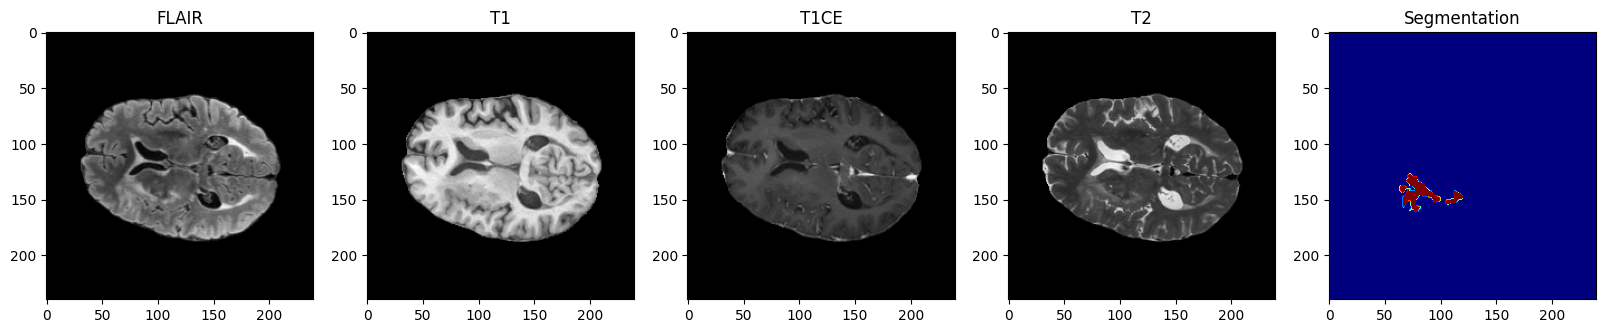

In [9]:
#Display slices from all modalities for a given sample
def visualize_sample(flair_file, t1_file, t1ce_file, t2_file, seg_file, slice_idx=None):
    #Load volumes, files
    flair = nib.load(flair_file).get_fdata()
    t1 = nib.load(t1_file).get_fdata()
    t1ce = nib.load(t1ce_file).get_fdata()
    t2 = nib.load(t2_file).get_fdata()
    seg = nib.load(seg_file).get_fdata()

    #Use the middle slice if no slice index is provided
    slice_idx = slice_idx or flair.shape[2] // 2

    #Plot all modalities and segmentation mask
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    axes[0].imshow(flair[:, :, slice_idx], cmap='gray')
    axes[0].set_title("FLAIR")
    axes[1].imshow(t1[:, :, slice_idx], cmap='gray')
    axes[1].set_title("T1")
    axes[2].imshow(t1ce[:, :, slice_idx], cmap='gray')
    axes[2].set_title("T1CE")
    axes[3].imshow(t2[:, :, slice_idx], cmap='gray')
    axes[3].set_title("T2")
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet')
    axes[4].set_title("Segmentation")
    plt.show()

#Visualize first sample
visualize_sample(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])

 - The MRIs are incredibly clean. Each instance has 4 modalities and a neurologist confirmed segmentation representing the ground truth of the glioma. MRIs do not have noise, random objects, blur, and are standardized to a given shape. Overall, clean dataset.

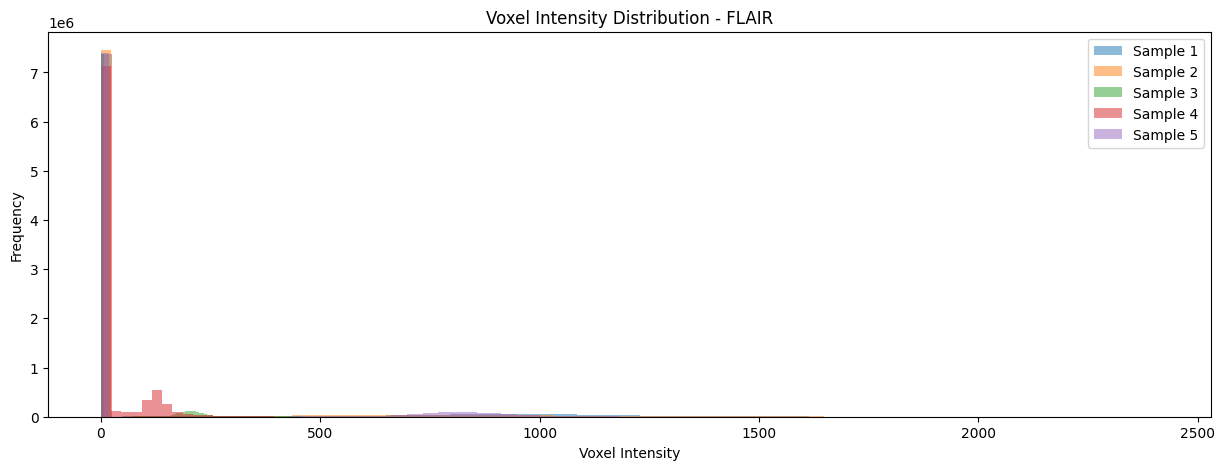

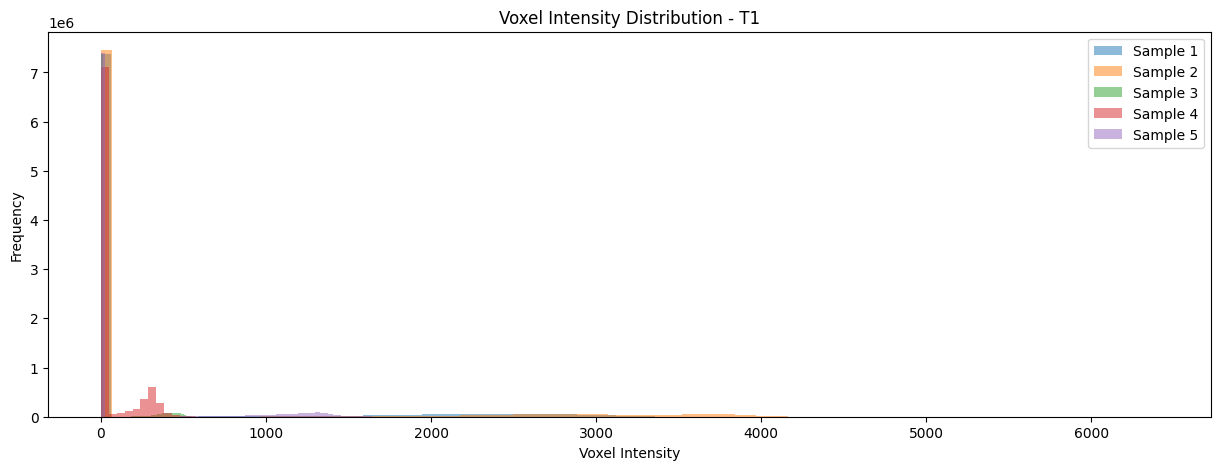

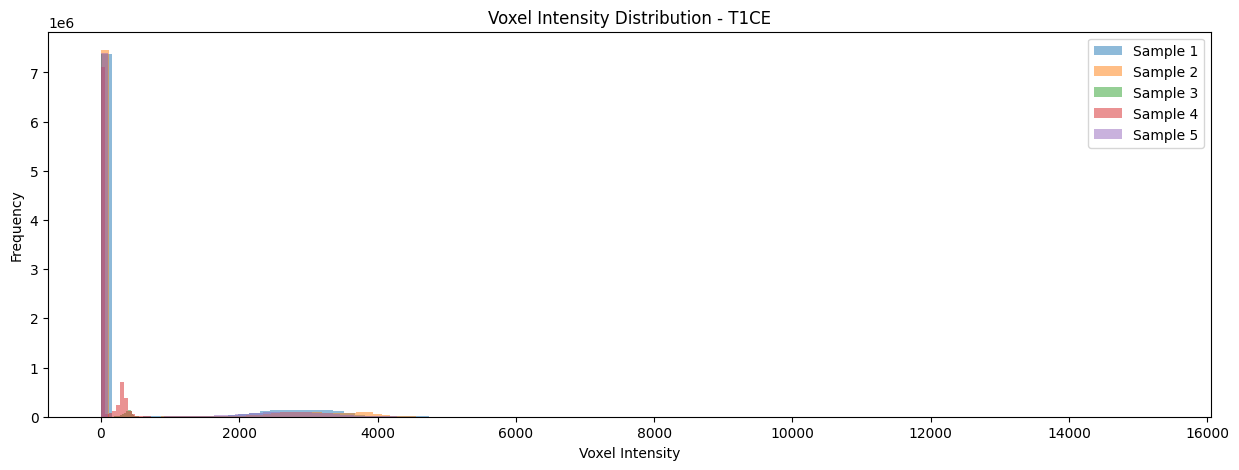

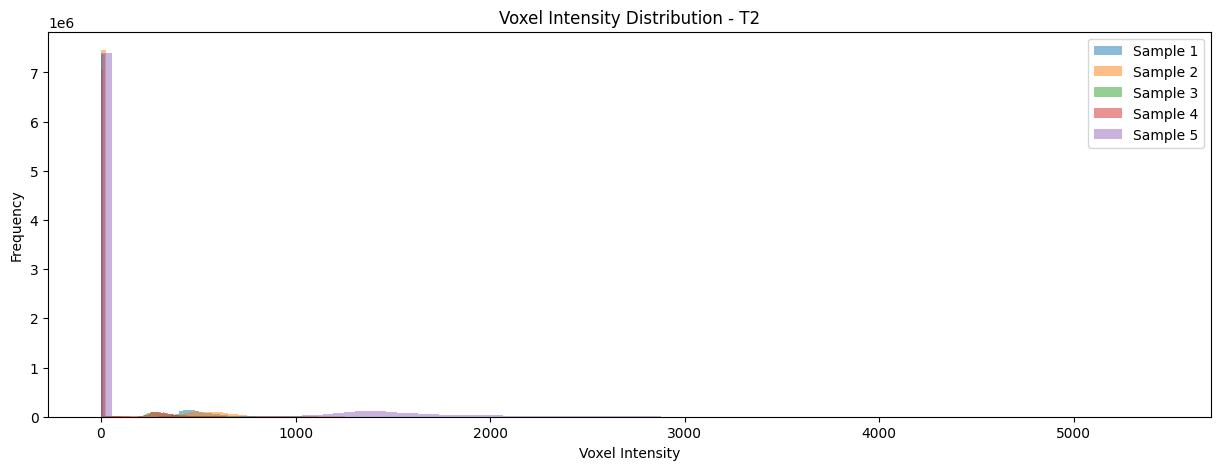

In [10]:
#Histograms for voxel intensities
def voxel_distributions(file_paths, modality_name, num_samples=5):
    plt.figure(figsize=(15, 5))
    #Check first few samples
    for i, file_path in enumerate(file_paths[:num_samples]):
        #Load volume data from file
        volume = nib.load(file_path).get_fdata()
        #Plot intensity
        plt.hist(volume.flatten(), bins=100, alpha=0.5, label=f"Sample {i+1}")
    plt.title(f"Voxel Intensity Distribution - {modality_name}")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot distributions for each modality
voxel_distributions(flair_files, "FLAIR")
voxel_distributions(t1_files, "T1")
voxel_distributions(t1ce_files, "T1CE")
voxel_distributions(t2_files, "T2")

 - The voxel distributions show some remarkable insight. 0 represents the black aspects of the image, but each modality has a unique intensity at a different peak. Overlap of multiple samples at different voxel intensities can likely be related to the intensity of the MRI taken for each as reflected in the above visual. Still, outlier voxel intensities can indicate an issue with the associated instance.

##Training

 - Given the clean nature of the dataset, we can proceed forward with training.

In [12]:
#Data splitting for training and validating. Will approach with standard 80/20 split
indices = list(range(len(flair_files)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=37)
#Print amount of instances in each to verify proper split
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")

Number of training samples: 1002
Number of validation samples: 251


 - Samples are precisely split into an 80% training, 20% validation set.

 - The below class composes all our methodologies for preprocessing. In it, we will calculate batches per epoch to understand resource allocation, load all modalities present within our data, and most importantly:

  - Stack all modalities as a channel along the last axis

  - Pad the depth of the input image dimension from 240 by 240 by 155 to 240 by 240 by 160 to ensure seamless down and upsampling across multiple layers

  - Double-check our data volume to ensure it contains useful information beyond a specified non-zero (black) voxel

  - Normalize the size of each modality to a range of [0, 1]

  - Perform data augmentation


In [13]:
#Data Generator for data loading and preprocessing across full dataset
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, batch_size=2, augment=False, useful_threshold=0.03):
        #Indices of dataset
        self.indices = indices
        #Samples per batch
        self.batch_size = batch_size
        #Applying data augmentation
        self.augment = augment
        #Threshold for uesful data based on non-zero voxel proportion
        self.useful_threshold = useful_threshold

    def __len__(self):
        #Calculate number of batches per epoch to understand resource allocation
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #Fetch one batch of data based on index with batch specific indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        #Initialized lists for input data and lables (X and y respectively)
        X, y = [], []
        for i in batch_indices:
            #Load all modalities for given index (up to 1253)
            flair = nib.load(flair_files[i]).get_fdata()
            t1 = nib.load(t1_files[i]).get_fdata()
            t1ce = nib.load(t1ce_files[i]).get_fdata()
            t2 = nib.load(t2_files[i]).get_fdata()
            seg = nib.load(seg_files[i]).get_fdata()

            #Check if the data volume contains enough "useful" non-zero voxels
            if (
                self._useful_volume(flair) < self.useful_threshold or
                self._useful_volume(t1) < self.useful_threshold or
                self._useful_volume(t1ce) < self.useful_threshold or
                self._useful_volume(t2) < self.useful_threshold
            ):
                print(f"[INFO] Skipping patient {i} due to insufficient useful volume.")
                continue

            #Stack modalities as channels along last axis
            input_image = np.stack([flair, t1, t1ce, t2], axis=-1)

            #Pad the depth dimension from 155 to 160 so we can feed it through the model w/o error
            pad_diff = 160 - input_image.shape[2]
            #If depth is less than 160, pad with 0
            if pad_diff > 0:
                input_image = np.pad(input_image, ((0, 0), (0, 0), (0, pad_diff), (0, 0)), mode='constant')
                seg = np.pad(seg, ((0, 0), (0, 0), (0, pad_diff)), mode='constant')

            #Normalize each modality independently to [0,1]
            input_image[..., 0] = self._normalize(input_image[..., 0])
            input_image[..., 1] = self._normalize(input_image[..., 1])
            input_image[..., 2] = self._normalize(input_image[..., 2])
            input_image[..., 3] = self._normalize(input_image[..., 3])

            #Convert segmentation mask to categorical format for multi-class segmentation
            seg = to_categorical(seg, num_classes=5)

            #Data augmentation
            if self.augment:
                #Randomly decide to augment
                if random.random() > 0.5:
                    #Generate random rotation angle
                    angle = random.uniform(-10, 10)
                    #Rotate image
                    input_image = rotate(input_image, angle, axes=(0, 1), reshape=False, mode='nearest')
                    #Rotate segmentation mask
                    seg = rotate(seg, angle, axes=(0, 1), reshape=False, mode='nearest')
            #Append preprocessed input to batch
            X.append(input_image)
            #Append preprocessed segmentation to batch too
            y.append(seg)
        #Return as Numpy array
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def _normalize(self, volume):
        """Normalize a 3D volume to the range [0, 1]."""
        return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    def _useful_volume(self, volume):
        """Calculate the proportion of useful volume (non-zero voxels)."""
        return 1 - (np.sum(volume == 0) / volume.size)

 - Now we preprocess our data. Note, retain batch sizing to 4 in order to prevent overload of RAM resources on A100 Runtime in Google Colab

 - We as well set a threshold of 3%, indicating that any MRI image with less than 3% of brain tissue showing should be eliminated from our dataset

In [14]:
#Instantiate training and validation generators
train_generator = DataGenerator(indices=train_indices, batch_size=4, augment=True, useful_threshold=0.03)
val_generator = DataGenerator(indices=val_indices, batch_size=4, augment=False, useful_threshold=0.03)

In [15]:
#Training instances applied
train_total_instances = len(train_generator.indices)
print(f"Total number of training instances: {train_total_instances}")

#Validation instances applied
val_total_instances = len(val_generator.indices)
print(f"Total number of validation instances: {val_total_instances}")

Total number of training instances: 1002
Total number of validation instances: 251


 - After preprocessing, we still retain the total amount of instances available in our dataset.

In [17]:
def unet_model(input_shape):
    #Input layer accepting 3D image with 4 channels (1 per modality)
    inputs = Input(input_shape)

    #Contracting Path (Encoder)
    #First block is to extrat features and reduce spatial dimesnions
    #Begin with 32 filter convolutional layer
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    #Normalize activations (improves convergence)
    conv1 = BatchNormalization()(conv1)
    #Additional convolution
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    #Downsample volume by factor of 2
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    #Second block with deeper feature extraction
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    #Third block (feature extraction continued)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    #Bottleneck. Captures high level features with reduced spatial resolution
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    #First Expansive Path (Decoder)
    #First block: Upsample and concatenate features from the contracting path
    up5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    #Skip connection with corresponding encoder layer
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    #Second block with continued upsampling and concatenating
    up6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    #Third block with upsampling
    up7 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    #Output layer with prediction of segmentation map with 5 classes (softmax generates probabilities to determine)
    outputs = Conv3D(5, (1, 1, 1), activation='softmax')(conv7)

    #Model variable with input/output layers
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


#Input shape with even depth to prevent mismatches
#Depth is even number (power of 2) with 4 channels
input_shape = (240, 240, 160, 4)
#instantiate model
model = unet_model(input_shape)
#Summarize model architecture for parameter check
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 240, 240, 160,  │              0 │ -                      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 240, 240, 160,  │          3,488 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 240, 240, 160,  │            128 │ conv3d[0][0]           │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 240, 240, 160,  │         27,680 │ batch_normalization[0… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 240, 240, 160,  │            128 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 120, 120, 80,   │              0 │ batch_normalization_1… │
│ (MaxPooling3D)            │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 120, 120, 80,   │         55,360 │ max_pooling3d[0][0]    │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 120, 120, 80,   │            256 │ conv3d_2[0][0]         │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 120, 120, 80,   │        110,656 │ batch_normalization_2… │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 120, 120, 80,   │            256 │ conv3d_3[0][0]         │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 60, 60, 40, 64) │              0 │ batch_normalization_3… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 60, 60, 40,     │        221,312 │ max_pooling3d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 40,     │            512 │ conv3d_4[0][0]         │
│ (BatchNormalization)      │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,608,069 (21.39 MB)

 Trainable params: 5,605,253 (21.38 MB)

 Non-trainable params: 2,816 (11.00 KB)

 - We now have a functional U-Net model ready for training. It remains relatively simple as far as 3D U-Net models go, however, fits within the resource limitations of Google Colab A100 High GPU runtime. Should equate to 38.1 / 41GB for GPU usage.

 - Dice Loss and Categorical Crossentropy were both chosen to provide a balanced and insightful loss metric. They will offer both the loss value as it pertains to the overlap between predicted and ground truth segmentation, as well as the voxel classification accuracy of each voxel at the predicted segmentation against the ground truth segmentation.


In [18]:
#Dice loss to measure overlap between predicted mask and ground truth
dice_loss = DiceLoss()
#Penalize pixel-wize misclassifications
crossentropy_loss = CategoricalCrossentropy()

 - Below is our complete function for training loss. Note: use @tf.keras.utils.register_keras_serializable() in order to save loss metrics to a .keras file for loading in later.

In [19]:
#Combined losses to balance region-level and pizel-level accuracy
@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + crossentropy_loss(y_true, y_pred)

 - Below is our host of metrics used for evaluation of our model. They are composed of:

  - accuracy (although there is little merit for this task)

  - IOUScore (which determines the overlap between predicted segmentation and ground truth as a ratio of their intersection relative to their union, providing a metric of accuracy to our segmentation boundaries)

  - F-Score (Similar model performance of accuracy at our segmentation, but without penalty to false positives and negatives as IOU Score. Provides a reference for improvement in comparison to IOU Score)

In [20]:
#Metrics for segmentation performace
#Intersection-Over-Union for overlap eval
#F1 Score for region precision/recall
#Pizel-wise accuracy
metrics = [IOUScore(threshold=0.5), FScore(threshold=0.5), 'accuracy']

 - In order to prevent getting trapped in local minima and continue model learning, we apply the ReduceLROnPlateau function to shift the learning rate to a different degree if there is no improvement in learning.

In [21]:
#Reduced learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    #Validation loss
    monitor='val_loss',
    #One-third the learning rate
    factor=0.3,
    #Wait 2 epochs without improvement
    patience=2,
    #Minimum LR
    min_lr=1e-4,
    #Print updates
    verbose=1
)

 - Given the large allotments of time required to train the model, we set up checkpoints at each epoch to save the model after maximum runtime is achieved in Google Colab. Therefore we can load in the model and continue training at a later time.

In [22]:
#Checkpoint callback
checkpoint = ModelCheckpoint(
    #Model name w/ epoch
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',
    #Validation loss
    monitor='val_loss',
    #only best model is saved
    save_best_only=True,
    #When val loss is minimized
    mode='min',
    #print out information on model
    verbose=1
)

 - Early stopping in case to prevent overfitting, although it remains highly unlikely

In [23]:
#Hopefully prevents overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    #Stop when val loss doesnt improve
    monitor='val_loss',
    #Wait 3 epochs before stopping
    patience=3,
    #Revert to best weights
    restore_best_weights=True
    )

 - The below wrappers are essential to ensure proper deserialization and load in the custom metrics for evaluating our model at a later point in training.

In [25]:
#Custom wrappers to ensure proper deserialization
@register_keras_serializable(package="Custom", name="IOUScore")
def custom_iou_score(**kwargs):
    return IOUScore(**kwargs)

@register_keras_serializable(package="Custom", name="FScore")
def custom_fscore(**kwargs):
    return FScore(**kwargs)

 **Note:** Only run the below code if loading in a previous model. The below function is required to load in a previously trained model to continue training with new runtime resource allocaiton

  - If needing to run the original model, simply comment our and the "model" variable should be defined to our unet_model above.

In [26]:
#Load model with all custom objects
model = load_model(
    'Modified_Model_6_epochs.keras',
    custom_objects={
        #Custom loss function
        'combined_loss': combined_loss,
        #Custom metric from segmentation library
        'IOUScore': custom_iou_score,
        'FScore': custom_fscore
    }
)

 - Model compilation with all metrics and features set.

In [27]:
#Compile the model with loss, optimizer, metrics
model.compile(optimizer='adam', loss=combined_loss, metrics=metrics)

 - Training the model

In [28]:
#Train model with generators, callbacks
history = model.fit(
    #Data Generator
    train_generator,
    #Validation generator
    validation_data=val_generator,
    #Iterations, try few others next
    epochs=4,
    #Display progress during training
    verbose=1,
    #Learning rate reduction, early stopping
    callbacks=[reduce_lr, early_stopping, checkpoint]
    )

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - accuracy: 0.9951 - f1-score: 0.7932 - iou_score: 0.7040 - loss: 0.4383 
Epoch 1: val_loss improved from inf to 0.50077, saving model to model_checkpoint_epoch_01.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 14346s 55s/step - accuracy: 0.9951 - f1-score: 0.7932 - iou_score: 0.7040 - loss: 0.4383 - val_accuracy: 0.9948 - val_f1-score: 0.7320 - val_iou_score: 0.6502 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 2/4
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.9955 - f1-score: 0.8106 - iou_score: 0.7231 - loss: 0.4119 
Epoch 2: val_loss improved from 0.50077 to 0.45240, saving model to model_checkpoint_epoch_02.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 11226s 43s/step - accuracy: 0.9955 - f1-score: 0.8106 - iou_score: 0.7231 - loss: 0.4119 - val_accuracy: 0.9944 - val_f1-score: 0.7908 - val_iou_score: 0.7028 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 3/4
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.9954 - f1-score: 0.8124 - iou_score: 

 **Note:** Model requires a lot of time to train, approximately 3.75 hours per epoch.

##Metrics and Results

 - Below is a function to visualize our metrics over the last runtime of epochs, with training and validation metrics reflected below.

In [29]:
def metrics_plot(history):
    #Extract metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]
    for metric in metrics:
        plt.figure(figsize=(10, 8))
        plt.plot(history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

 - Call function to visualize metrics

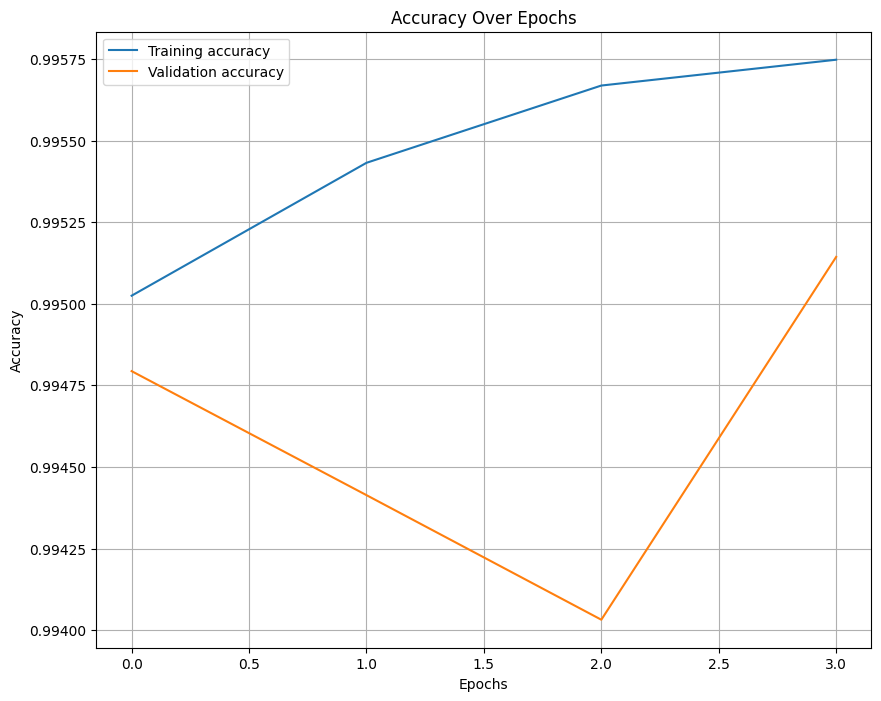

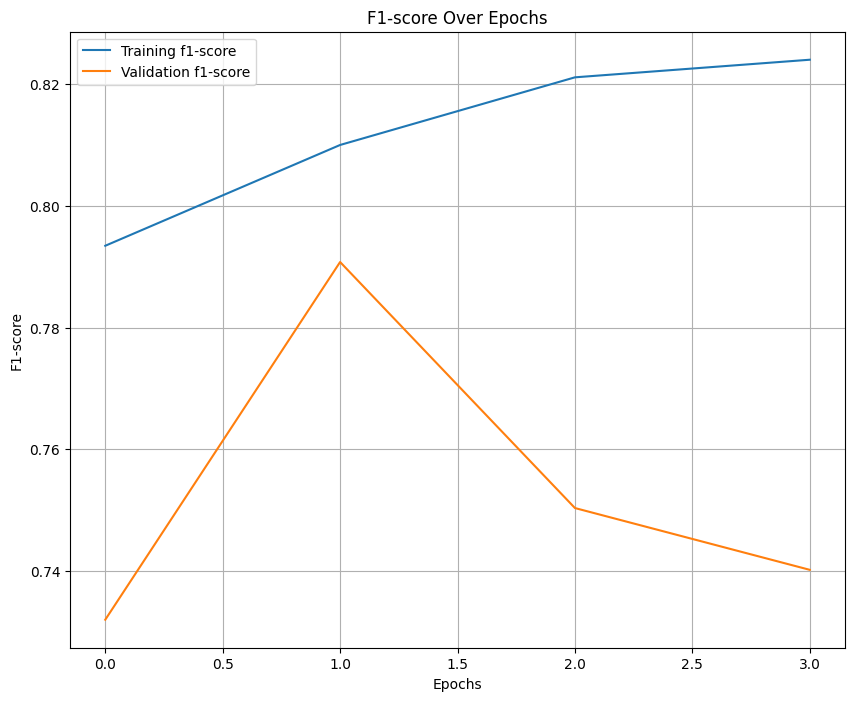

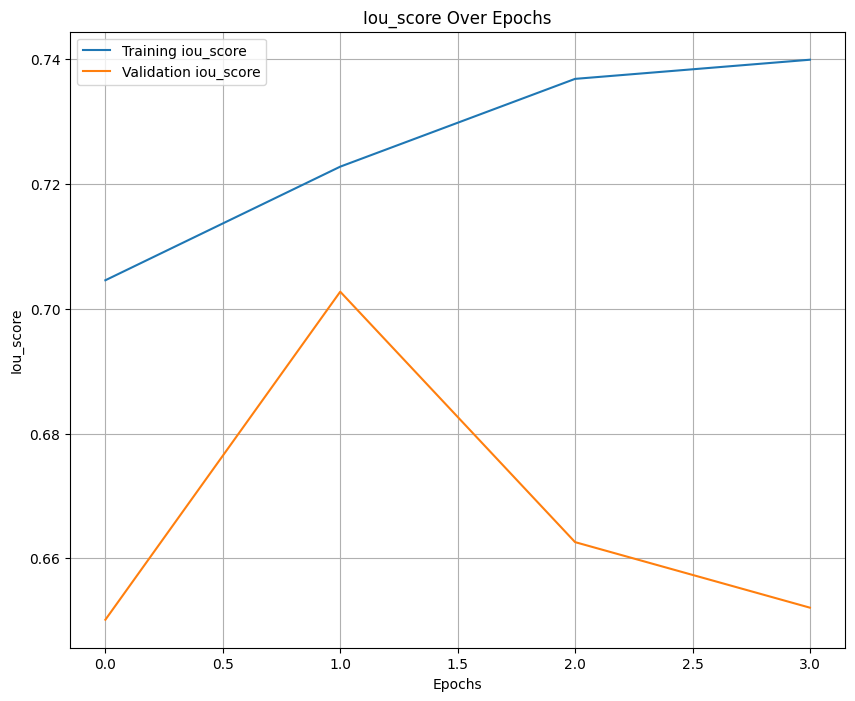

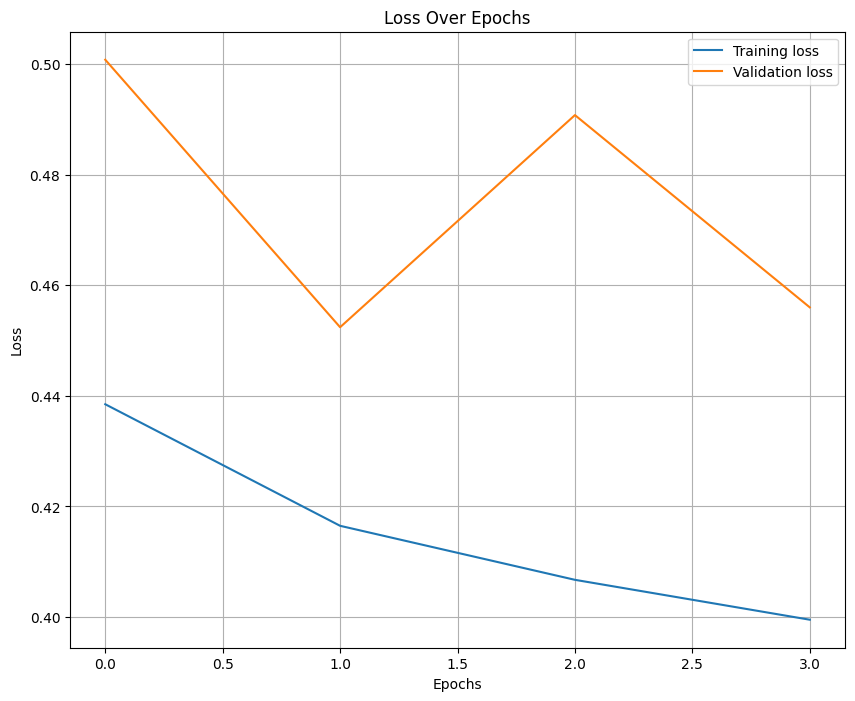

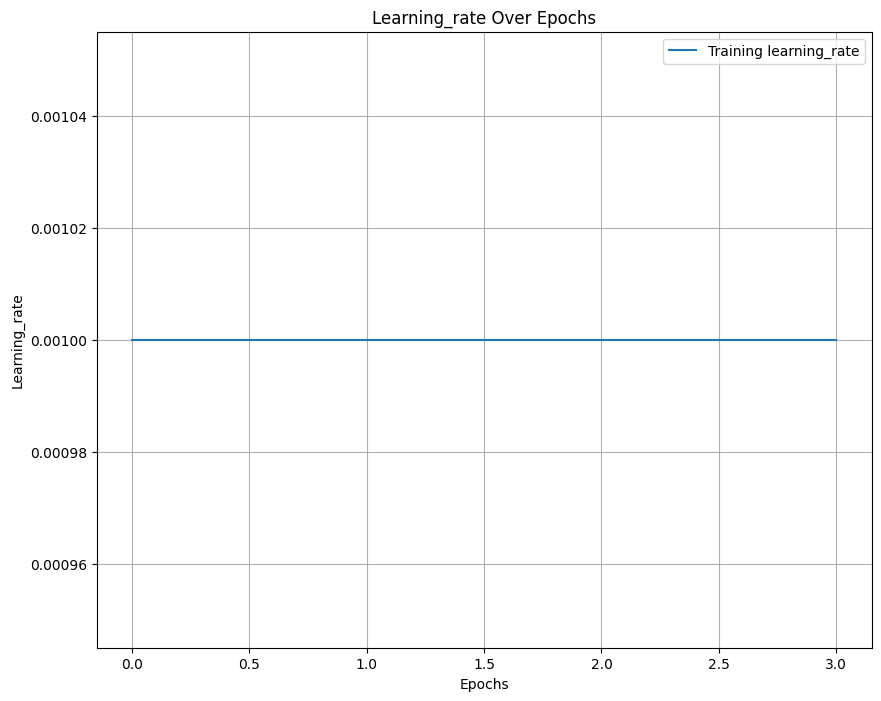

In [30]:
metrics_plot(history)

 - Overall, our metrics are relatively great. However, the visuals only reflect the previous runtime of 4 epochs, and do not offer the full view of trianing management.

 - Let's obtain some concrete figures below.

In [31]:
def print_metrics(history):
    #Extract metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]

    for metric in metrics:
        #Print all values
        print(f"\n{metric.capitalize()} Values Over Epochs:")
        print(f"Training {metric}: {history.history[metric]}")
        if f"val_{metric}" in history.history:
            print(f"Validation {metric}: {history.history[f'val_{metric}']}")


In [32]:
#Call function to see results
print_metrics(history)


Accuracy Values Over Epochs:
Training accuracy: [0.995024561882019, 0.9954317212104797, 0.9956684708595276, 0.9957475662231445]
Validation accuracy: [0.9947934150695801, 0.9944134950637817, 0.9940317869186401, 0.9951434135437012]

F1-score Values Over Epochs:
Training f1-score: [0.7934303283691406, 0.8099790811538696, 0.8210851550102234, 0.8239758014678955]
Validation f1-score: [0.732033908367157, 0.7907635569572449, 0.7503693699836731, 0.7402228713035583]

Iou_score Values Over Epochs:
Training iou_score: [0.7045858502388, 0.7227997779846191, 0.7368743419647217, 0.7399448752403259]
Validation iou_score: [0.6501575112342834, 0.7027507424354553, 0.6625991463661194, 0.6520891785621643]

Loss Values Over Epochs:
Training loss: [0.4384726285934448, 0.41648975014686584, 0.4067210853099823, 0.3995061218738556]
Validation loss: [0.5007746815681458, 0.4524010419845581, 0.4907603859901428, 0.4559890329837799]

Learning_rate Values Over Epochs:
Training learning_rate: [0.0010000000474974513, 0.

 - Overall, the results are incredibly promising. The highest achieved IOU score is 73% in training and 70% in validation, reflecting significant accuracy and overlap in our predicted segmentation compared to the ground truth, with a relatively low loss value indicating likewise accurate prediction of tissue classification.

 - The higher F-score value compared to the IOU Score indicates a problem in our model of false positives predictions.

 - Below code is to save the model in a .keras format with all model weights, architecture, and metrics.

In [33]:
#Save trained model for later use
model.save('Modified_Model_10_epochs.keras')

 - As a precautionary measure, we also have the below function to download both the model and all model checkpoints at every epoch. Given that each epoch takes approximately 3.75 hours, it is better to be safe than sorry if Runtime disconnects.

In [34]:
def model_checkpoints(folder_path="./"):
    #Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    #Collect all .keras files in the folder
    keras_files = [f for f in os.listdir(folder_path) if f.endswith('.keras')]
    if not keras_files:
        print("No .keras files found in the specified folder.")
        return

    #Zip file name
    zip_file_name = "Model_10_epochs.keras.zip"

    #Zip only .keras files
    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        for file in keras_files:
            zipf.write(os.path.join(folder_path, file), arcname=file)

    print(f"Zipped .keras files from '{folder_path}' into '{zip_file_name}'")

    #Download
    try:
        files.download(zip_file_name)
        print("Download started...")
    except Exception as e:
        print(f"Error during download: {e}")


In [35]:
#Save everything
model_checkpoints()

Zipped .keras files from './' into 'Model_10_epochs.keras.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


##Visualization of Results

 - In order to better visualize our predicted segmentations, we apply the below function

In [36]:
#Refine the predicted segmentation masks
def post_process_prediction(prediction):
    #Convert predictions to class labels
    prediction = prediction.argmax(axis=-1)
    #Apply morphological closing to fill gaps and remove noise
    #Loop through each slice in depth
    for i in range(prediction.shape[2]):
        #Convert to 8-bit for morphological operations, use 5x5 kernel
        prediction[:, :, i] = cv2.morphologyEx(prediction[:, :, i].astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    return prediction

 - Now we add an outline of the mask onto the image using edge detection

In [37]:
def add_outline(image, mask, outline_color=(255, 0, 0)):
    #Normalize the input image to range [0, 255] if necessary
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    #Detect edges using Canny edge detection
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)

    #Convert grayscale to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    #Add the outline to the RGB image
    overlay[edges > 0] = outline_color

    return overlay

 - In order to identify the different classifications of tissues, we apply a color mapping to the segmentation mask

In [38]:
def class_color(mask):
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255

    print("Class-Color Mapping:")
    for label, color in zip(unique_labels, colors):
        print(f"Class {int(label)}: RGB {tuple(color.astype(int))}")

 - Next, we also set up plotting the predicted segmentation with both class color and aforementioned outline.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


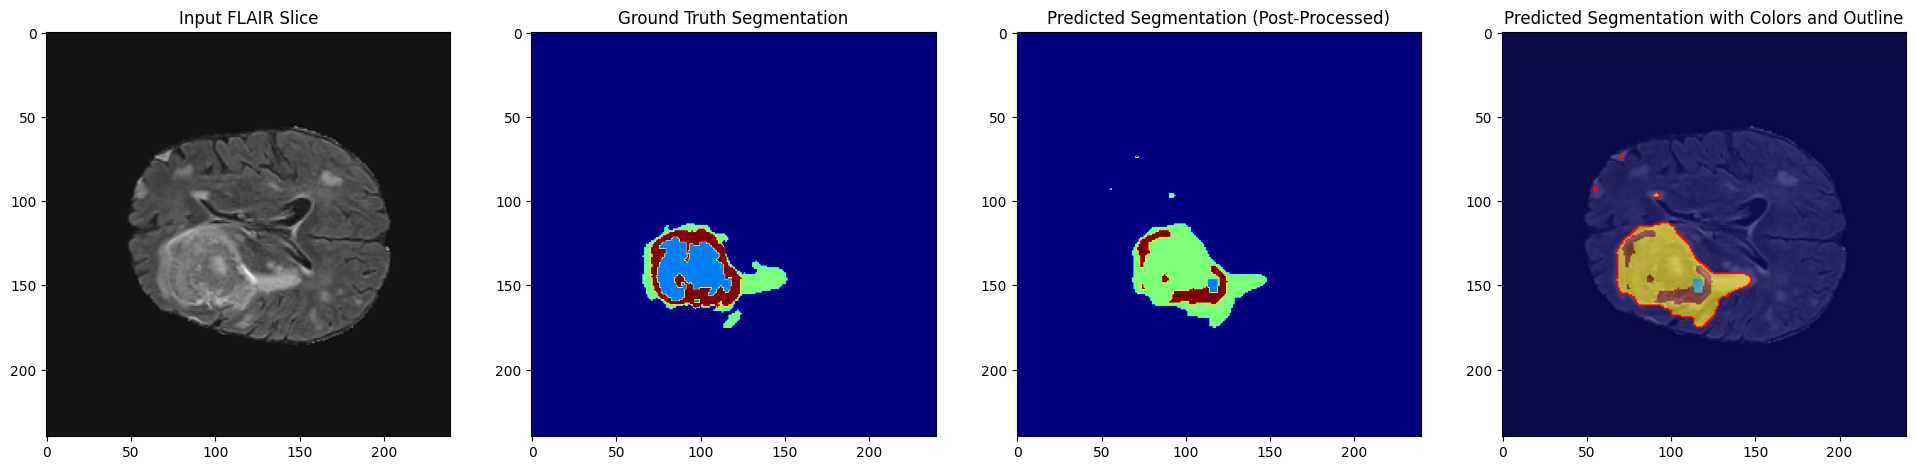

In [43]:
# Visualize predictions with colored segmentation and outline
def predictions_colored_segmentation(model, index):
    #Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    #Predict segmentation
    y_pred = model.predict(X)[0]
    #Post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    #Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    #Print class-color mapping
    print("Predicted Segmentation Class-Color Mapping:")
    class_color(predicted_slice)

    #Add colored segmentation and outline
    predicted_with_colors_and_outline = colored_segmentation_outline(input_slice, predicted_slice)

    #Plot truth, input, predictions, and overlayed segmentation with outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_colors_and_outline)
    axes[3].set_title('Predicted Segmentation with Colors and Outline')
    plt.show()

# Example usage
predictions_colored_segmentation(model, index=0)

 - As can be visualized above, our model performs a relatively good job at classifying and segmenting glioblastoma tumors within the brain. It captures the overall region and, relatively, the correct tissue classes within segmented portions of the brain. Considering that the model only trained for 10 epochs, this is a resoundingly powerful result. It is important to note:

  - Red: represents necrotic core of dead tissue at center of glioblastoma

  - Green: represents swelling around the tumor

  - Yellow: represents actively growing portion of glioma


 - Below is a helper function for our Gif. it will add the segmentation mask and its outline to an image.


In [40]:
def colored_segmentation_outline(image, mask, outline_color=(255, 0, 0)):
    #Normalize the input image to range [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    #Convert grayscale image to RGB
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    #Create a colored version of the mask
    colored_mask = np.zeros_like(overlay)
    unique_labels = np.unique(mask)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))[:, :3] * 255

    for label, color in zip(unique_labels, colors):
        colored_mask[mask == label] = color

    #Blend the colored mask with the image
    alpha = 0.5
    overlay = cv2.addWeighted(overlay, 1 - alpha, colored_mask, alpha, 0)

    #Detect edges
    edges = cv2.Canny(mask.astype(np.uint8) * 255, threshold1=50, threshold2=150)
    overlay[edges > 0] = outline_color

    return overlay

 - Lastly, as a full reference comparison, we create 2 GIFs to compare our results, the first of the original FLAIR MRIs, and the other of our predicted segmentation with class color.

In [41]:
def 3d_gifs(model, index, flair_output_path="flair_images.gif", segmentation_output_path="predicted_segmentation.gif"):
    #Grab input and ground truth for the batch
    X, _ = train_generator[index]
    # Predict segmentation
    y_pred = model.predict(X)[0]
    #Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)

    #Print class-color mapping for the first slice
    print("Class-Color Mapping for the First Predicted Slice:")
    class_color(y_pred_post_processed[:, :, 0])

    #Prepare directories for temporary frames
    temp_flair_dir = "temp_flair_frames"
    temp_seg_dir = "temp_seg_frames"
    os.makedirs(temp_flair_dir, exist_ok=True)
    os.makedirs(temp_seg_dir, exist_ok=True)

    #Create individual frames for each slice
    flair_frames = []
    seg_frames = []
    #Iterate through all slices in the depth dimension
    for i in range(X[0].shape[2]):
        #Extract the input FLAIR slice
        input_slice = X[0][:, :, i, 0]
        #Extract the predicted segmentation for the slice
        predicted_slice = y_pred_post_processed[:, :, i]

        #Save FLAIR slice as a frame
        flair_frame_path = os.path.join(temp_flair_dir, f"flair_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(input_slice, cmap="gray")
        plt.title(f"FLAIR Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(flair_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        flair_frames.append(flair_frame_path)

        #Add colored segmentation and outline
        overlay = colored_segmentation_outline(input_slice, predicted_slice)

        #Save segmentation slice as a frame
        seg_frame_path = os.path.join(temp_seg_dir, f"seg_frame_{i:03d}.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(overlay)
        plt.title(f"Predicted Segmentation Slice {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(seg_frame_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        seg_frames.append(seg_frame_path)

    #FLAIR GIF
    with imageio.get_writer(flair_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in flair_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    #Segmentation GIF
    with imageio.get_writer(segmentation_output_path, mode="I", duration=0.1, loop=0) as writer:
        for frame in seg_frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    #Clean up temporary frames
    for frame in flair_frames:
        os.remove(frame)
    os.rmdir(temp_flair_dir)

    for frame in seg_frames:
        os.remove(frame)
    os.rmdir(temp_seg_dir)

    print(f"FLAIR GIF saved as {flair_output_path}")
    print(f"Segmentation GIF saved as {segmentation_output_path}")

    #Display
    print("Displaying FLAIR GIF:")
    display(Image(flair_output_path))
    print("Displaying Segmentation GIF:")
    display(Image(segmentation_output_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class-Color Mapping for the First Predicted Slice:
Class-Color Mapping:
Class 0: RGB (0, 0, 127)


<ipython-input-40-48d985c5c610>:14: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min()) * 255
<ipython-input-40-48d985c5c610>:15: RuntimeWarning: invalid value encountered in cast
  image = image.astype(np.uint8)
<ipython-input-41-1a70db16c3eb>:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
<ipython-input-41-1a70db16c3eb>:71: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


FLAIR GIF saved as flair_images.gif
Segmentation GIF saved as predicted_segmentation.gif
Displaying FLAIR GIF:


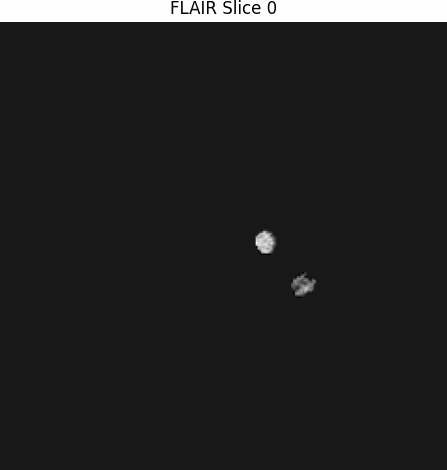

Displaying Segmentation GIF:


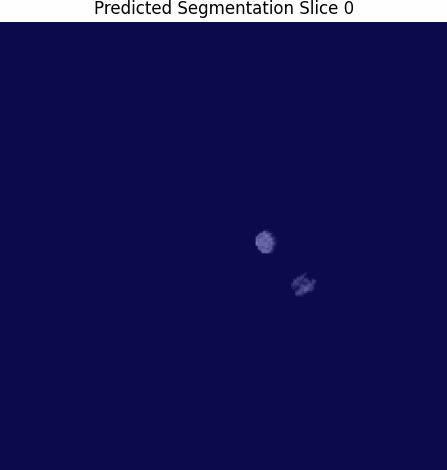

In [42]:
3d_gifs(
    model,
    index=0,
    flair_output_path="flair_images.gif",
    segmentation_output_path="predicted_segmentation.gif"
)

 - For ease of visual use, we only include the segmentation without class color included, to demonstrate the underlying predictive capability of our U-Net model.

In [44]:
def outline_only_pred(model, index):
    #Grab input and ground truth for the batch
    X, y_true = train_generator[index]
    #Predict segmentation
    y_pred = model.predict(X)[0]
    #Apply post-processing
    y_pred_post_processed = post_process_prediction(y_pred)
    #Extract a single slice for visualization
    input_slice = X[0][:, :, X[0].shape[2] // 2, 0]
    ground_truth_slice = y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1)
    predicted_slice = y_pred_post_processed[:, :, X[0].shape[2] // 2]

    #Add outline to the predicted segmentation
    predicted_with_outline = add_outline(input_slice, predicted_slice, outline_color=(255, 0, 0))

    #Plot truth, input, predictions, and overlayed outline
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_slice, cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(ground_truth_slice, cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(predicted_slice, cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    axes[3].imshow(predicted_with_outline)
    axes[3].set_title('Predicted Segmentation with Brain Outline')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


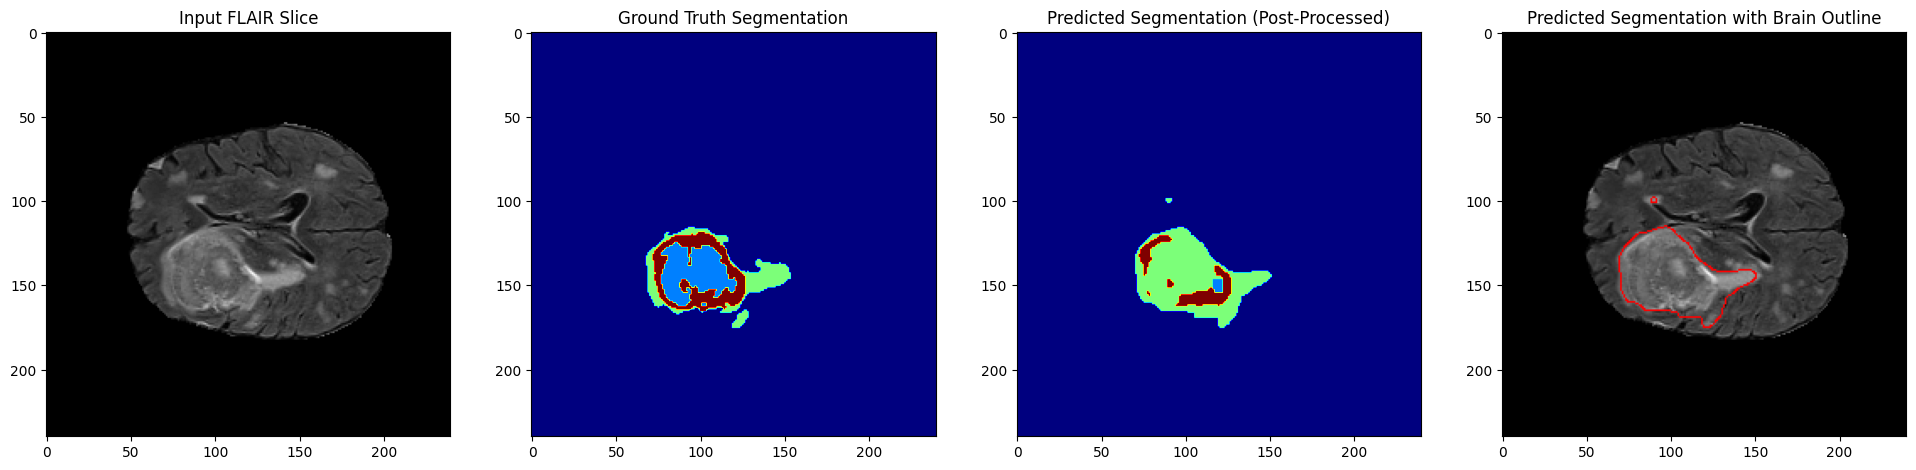

In [45]:
outline_only_pred(model, index=0)

##Conclusion

Overall, the model was relatively successful. Despite the resource restraints limiting the depth and complexity of the U-Net model to abstract features from the MRI images, the scores remained promising and further reflect the serious potential of computer vision models predicting and isolating developing glioblastomas before onset symptoms present. In essence, we succesfully segmented and classified different types of glioma tumors from MRI images that may have otherwise been missed entirely or misdiagnosed between multiple doctors.